<a href="https://colab.research.google.com/github/MinahilRaza/ClusteringAnalysis/blob/main/ClusteringAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Analysis
The method consists of three steps
1. Building the correlation matrix
1. Ordering the correlation matrix
3. Identifying the clusters

First, import the necessary python packages

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from copy import deepcopy

## Building the Correlation Matrix
The Z-score table T is RxC matrix with R rows and C columns. First, we calculate the correlation matrix for rows and columns. Let's consider the correlation matrix A for the rows. It is an RxR matrix. Let each row be a vector, then for R rows, we calculate a correlation value with each row.

In [ ]:
def CreateSimilarityMatrix(X: np.ndarray, direction = 'row'):
    '''
    Returns the correlation matrix for rows or columns from a zscore table.

    Parameters:
        X (np.ndarray): The zscore table.
        direction (str): 'row' for row-wise similarity matrix
                         'col' for column-wise similarity matrix

    Returns:
        The correlation matrix for dpecified direction.   
    '''  

    if direction == 'col':
      X = X.T
    elif direction != 'row':
      print("Incorrect value for direction. Can be \'row\' or \'col\'")
    
    matrix = np.dot(X,X.T)
    # Calculate arrays with magnitudes of vectors
    p1 = np.sqrt(np.sum(X**2,axis=1))[:,np.newaxis]
    p2 = np.sqrt(np.sum(X**2,axis=1))[np.newaxis,:]
    # Normalize to find cosine
    matrix = matrix/(p1*p2)

    return matrix

In [ ]:
def RandomizeOrder(n:int):
   '''
    Returns the randomized kernel order

    Parameters:
        n (int): size of kernel orders.

    Returns:
        The randomized kernel order.   
    '''
   order = [i for i in range(0,n)]
   random.shuffle(order)
   return order

In [ ]:
import os
def gauss(variance):
  # between 0 and 0.999999999999
  x1 = np.random.uniform()
  x2 = np.random.uniform()
  return variance*np.sqrt( - 2*np.log(x1) )* np.cos( 2* np.pi* x2) 

# room for refactoring in makechangevectors
def MakeChangeVectors(order, line1, line2, width, n, klines):
  # reutrn change, nochange, int
  change = []
  nochange= []
  nk = len(klines)
  line1 = int(line1)
  line2 = int(line2)
  for i in range(0, width):
    in1 = order[line1 + i]
    jmax = n - klines[in1]
    if (in1 != nk - 1):
      jmax = klines[in1+1] - klines[in1]
    for j in range(0, jmax):
      change.append(klines[in1] + j)
  if line1 < line2:
    for i in range(line1 + width, line2 + width):
      in1 = order[i]
      jmax = n-klines[in1];
      if in1 != nk-1:  
        jmax = klines[in1+1] - klines[in1];
      for j in range(0, jmax):
        change.append(klines[in1] + j)
  if line1 > line2:
    for i in range(line2, line1):
      in1 = order[i]
      jmax = n-klines[in1];
      if in1 != nk-1:  
        jmax = klines[in1+1] - klines[in1];
      for j in range(0, jmax):
        change.append(klines[in1] + j)
  for i in range(0, n):
    if i not in change:
      nochange.append(i)
  return change, nochange

def ChangeSegmentOrder(order,line1,line2,width):
   # RECHECKED
   pos = []
   line1 = int(line1)
   line2 = int(line2)
   for i in range(0, width):
     pos.append(order[line1 + i]) # can be refactored
   if line1 < line2:
    j = 0
    for i in range(line1 + width, line2 + width):
      order[line1 + j] = order[i]
      j = j+1 #refactor
    for i in range(0, width):
      order[line2 + i] = pos[i]
   if line1 > line2:
    for i in range(line1-1, line2-1, -1): # redesign this
      order[i + width] = order[i]
    for i in range(0, width):
      order[line2 + i] = pos[i]
   return order




def EnergyChangeReOrd(mat, l1, l2, w, n, kernelOrder, klines):
  # need to return delta E and order
  deltaen = 0
  lchange, lfix = MakeChangeVectors(kernelOrder, l1, l2, w, n, klines)
  oldorder = GetNodeOrder(kernelOrder, klines, n, 0)
  newKernelOrder=kernelOrder
  newKernelOrder = ChangeSegmentOrder(newKernelOrder,l1,l2,w)
  newOrder = GetNodeOrder(newKernelOrder, klines, n, 0)
  for i in range(0, len(lchange)):
    for j in range(0, len(lfix)):
      line1 = lchange[i]
      line2 = lfix[j]
      deltaen = deltaen + 2*mat[line2][line1]* (np.abs(newOrder[line1]- newOrder[line2])-
                                       np.abs(oldorder[line1]-oldorder[line2]))/n
  x = len(lchange) -1
  for i in range(0, x):
      for j in range(i + 1 ,len(lchange)):
        line1 = lchange[i]
        line2 = lchange[j]
        deltaen = deltaen + 2*mat[line2][line1]* (np.abs(newOrder[line1]- newOrder[line2])-
                                       np.abs(oldorder[line1]-oldorder[line2]))/n
  return deltaen, newKernelOrder # see if you need to return order


def AnnealStep(temperature, matrix, netSize, order, nblocks, klines):
  # needs to return order and deltaE
  nkernels = len(klines)
 
  width = int(np.fabs(gauss(np.sqrt(temperature)*0.05*nkernels))) + nblocks
  width = width- (width%nblocks)
  #line1 = width/2 + (int)( (nkernels-width)*random.random())
  line1 = int( (nkernels-width)*np.random.uniform())
  #line1 = int( (nkernels-width)*0.5)
  #line1 = line1 - width/2
  line1 = line1 - line1%nblocks
  line1 = np.max([line1, 0])
  while( width > nkernels-line1 ):
    width = int(np.fabs(gauss(np.sqrt(temperature)*0.05*nkernels))) + nblocks
    width = width- (width%nblocks)
  line2 = int(gauss(np.sqrt(temperature)*0.1))
  if line2<0:
    line2= line2 - line1
    line2 = np.max([line2, 0])
  else:
    line2 = line2 + line1 + width
    if line2 > nkernels-width:
       line2 = nkernels-width #can be replaced by min func
  line2 = line2 - (line2%nblocks)
  # see if order changes in this function
  #if line2>50:
  deltaE, _ =  EnergyChangeReOrd( matrix, line1, line2, width, netSize, deepcopy(order), klines)
  if temperature == 0:
    prob = 0
  else:
    prob = np.exp( -deltaE/temperature )
  if np.random.uniform() < prob:
    # no need to return
    order = ChangeSegmentOrder( order, line1, line2, width);
    return deltaE, order
  return 0, order

In [ ]:
# GetNodeOrder

# this needs to be refactored. remove redundant lines of code
def GetNodeOrder(kernelOrder, klines, netSize:int, option: int):
  # RECHECKED
  nodeOrder = np.zeros((netSize))
  if option == 0:
    k = 0
    for i in range(0, len(kernelOrder)):
      jmax = netSize-klines[kernelOrder[i]]
      if kernelOrder[i]!=len(kernelOrder)-1:
        jmax=klines[kernelOrder[i]+1]-klines[kernelOrder[i]]
      for j in range(0, jmax):
        nodeOrder[klines[kernelOrder[i]]+j]=k
        k = k + 1
  if option == 1:
    k = 0;
    for i in range(0, len(kernelOrder)):
      jmax = netSize-klines[kernelOrder[i]]
      if kernelOrder[i]!=len(kernelOrder)-1:
        jmax=klines[kernelOrder[i]+1]-klines[kernelOrder[i]]

      for j in range(0, jmax):
        nodeOrder[k]=klines[kernelOrder[i]]+j
        k = k + 1
  return nodeOrder

In [ ]:
def ComputeEnergy(mat, netSize, kernelOrder, klines):
  # only needs to return the energy
  energy = 0.0
  nodeOrder = GetNodeOrder(kernelOrder, klines, netSize, 1 )
  for i in range(0, netSize-1):
    for j in range(i+1, netSize):
      a = int(nodeOrder[i])
      b = int(nodeOrder[j])
      energy = energy + 2*np.abs(i-j)*mat[b][a]/netSize
  return energy

In [ ]:
# GetKernels Function

def GetKernels(similarityMatrix:np.ndarray, n:int, translationTable:list):
  '''
    Rearranges similarity matrix and finds kernel.

    Parameters:
        similarityMatrix (np.ndarray): The similarity matrix (row or col wise).
        n (int): dimensions of similarityMatrix are n*n
        translationTable (list): the initial translation table            

    Returns:
        similarityMatrixNew: The new similarity matrix 
        kernelOrder: The order of kernels
        kkline: list of lines at which each kernel starts
        n: dimension of similarity matrix
        translationTableNew: the new translation table
        kernelList: The list of nodes inside each kernel
   
    '''  
  nn = n
  kernelsize = []
  knodelist = []
  # NOTE: list of list
  kernelList = [] # list of nodes inside each kernel
  kernelOrder = [] # order of kernels
  kkline = [] # list of lines at which each kernel starts
  assignedNodes = [] # previously assigned nodes
  translationTableNew = []
  # NOTE: see if you need sim matrix new, fix length of transtablenew
  nodeCount = 0
  kernelCount = 0
  
  for i in range(0, nn):
    if i not in assignedNodes:
      knodelist.append(nodeCount)
      kkline.append(nodeCount)
      kernelOrder.append(kernelCount)
      assignedNodes.append(i)
      # see if this needs to be changed
      translationTableNew.append(translationTable[i])
      nodeCount =  nodeCount + 1
      for j in range(i+1, nn):
        if similarityMatrix[j][i] == 1:
          knodelist.append(nodeCount)
          assignedNodes.append(j)
          translationTableNew.append(translationTable[j])
          nodeCount =  nodeCount + 1
      kernelCount = kernelCount + 1
      kernelList.append(knodelist)
      kernelsize.append(len(knodelist))
      knodelist = [] # clear list
  nn = len(assignedNodes)
  similarityMatrixNew = np.zeros((nn,nn))
  for i in range(0, len(assignedNodes)):
    for j in range(i, len(assignedNodes)):
      similarityMatrixNew[i][j] = similarityMatrix[assignedNodes[j]][assignedNodes[i]]
      similarityMatrixNew[j][i] = similarityMatrix[assignedNodes[j]][assignedNodes[i]]
  
  n = len(kernelList)
  return similarityMatrixNew, kernelOrder, kkline, n, translationTableNew, kernelList


In [ ]:
def AnnealIter(temperature: float, matrix, nsteps, n, order, energy, nblocks, kline):
  # need to return energy and order
  for step in range(0, nsteps):
    deltaen, order =  AnnealStep(temperature, matrix, n, order, nblocks, kline)
    energy = energy + deltaen
  return order, energy

In [ ]:
def OrderKernel(similarityMatrix,randomization, T, factor):
  EPS = 0.00000001
  n = similarityMatrix.shape[0]
  translationTable = [i for i in range(0, n)]
  similarityMatrix, kernelOrder, klines, nkernels, translationTable,\
      kernels = GetKernels(similarityMatrix, n, translationTable)
  if randomization == 1:
    kernelOrder  = RandomizeOrder(n)
  energyold = ComputeEnergy(similarityMatrix, n, kernelOrder, klines)
  energy = energyold
  count = 0
  nblocks = 1
  # atleast perform 10 steps
  Nsteps = np.max([int(0.01*(nkernels/nblocks)**2), 10])
  iter = 0
  if nkernels >2:
    while count<20:
      kernelOrder, energy = AnnealIter(T,similarityMatrix, Nsteps, n, kernelOrder, energy, nblocks, klines)
      if np.fabs( energyold - energy ) < EPS: 
          count = count + 1
          
      else:
        count = 0
      energyold = energy
      T = T* factor
      iter = iter + 1
  sim = np.zeros((n,n))
  nodeOrder = GetNodeOrder( kernelOrder, klines, n, 1)
  for i in range(0, n):
    i1 = int(nodeOrder[i])
    for j in range(0,n):
      j1 = int(nodeOrder[j])
      sim[i][j] = similarityMatrix[j1][i1]
  return kernelOrder, sim

In [148]:
def VisualizeClusters(unordered_mat, ordered_mat, labels, kernelOrder, partition, save, filename):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
  sns.heatmap(unordered_mat, cmap= 'YlOrRd', ax=ax1, vmin=-1, vmax=1)
  ax1.set_title('Unordered Matrix')
  ax1.set_xticks(np.arange(len(labels))+0.5)
  ax1.set_xticklabels(labels, rotation = 90)
  ax1.set_yticks(np.arange(len(labels))+0.5)
  ax1.set_yticklabels(labels, rotation = 0)

  sns.heatmap(ordered_mat, cmap= 'YlOrRd', ax=ax2, vmin=-1, vmax=1)
  ax2.set_title('Ordered Matrix')
  ax2.set_xticks(np.arange(len(labels))+0.5)
  ax2.set_xticklabels(labels[kernelOrder], rotation = 90)
  ax2.set_yticks(np.arange(len(labels))+0.5)
  ax2.set_yticklabels(labels[kernelOrder], rotation =0)

  # plot cluster boundaries
  for part in partition:
    ax2.add_patch(
      patches.Rectangle(
          (part[0], part[0]),
          part[1]-part[0]+1,
          part[1]-part[0]+1,
          edgecolor='black',
          fill=False,
          lw=4
      ) )

  fig.tight_layout()
  if save:
    plt.savefig(filename,dpi=200)
    df = pd.DataFrame(ordered_mat, labels[kernelOrder], columns=labels[kernelOrder])
    df.to_excel(filename.replace('.png', '.xlsx'))
  plt.show()

In [149]:
zscores = pd.read_csv('matrix2.csv') #add options for other formats

my_data = zscores[zscores.columns[1:]].to_numpy()
zscores = zscores.set_index('ZSCORES')

S1 = CreateSimilarityMatrix(my_data, 'row')
S2 = CreateSimilarityMatrix(my_data, 'col')

NoofRows = S1.shape[0]
NoofCols = S2.shape[0]

In [ ]:
def GetKernelRows(similarityMatrix, netSize):
    kernelRows = [0]
    nrow = 0
    for row in range(0, netSize):
     for col in range(row+1, netSize):
      row = col
      if similarityMatrix[col][nrow]!=1:
        kernelRows.append(col)
        nrow = col
        break
    return kernelRows

In [ ]:
def InitializePartition(nbox, netSize):
  partition = []
  tempPart = [0]
  node = 0
  for i in range(0,nbox-1):
    node += int((netSize - nbox + i - node)* np.random.uniform())
    tempPart.append(node)
    partition.append(tempPart)
    node = node + 1
    tempPart = [node]
  tempPart.append(netSize-1)
  partition.append(tempPart)
  return partition

In [ ]:
def AddPartition(partition, nPart, kernel):
  dummy = []
  partitionnew = []
  for  j in range(0, len(partition)):
    if j== nPart:
      dummy = []
      dummy.append(partition[j][0])
      dummy.append(kernel)
      partitionnew.append(dummy)
      dummy = []
      dummy.append(kernel+1)
      dummy.append(partition[j][1])
      partitionnew.append(dummy)
    else:
      partitionnew.append(partition[j])
  return partitionnew


In [ ]:
def ComputeLeastSquares(similarityMatrix, partition, netSize, kernelRows):
  numberBoxes = len(partition)
  leastSquares = 0
  boxAverage=0
  boxAverageSq=0
  outAverage=0
  outAverageSq=0
  AverageTotal=0
  AverageSqTotal=0
  inCount=0
  outCount=0
  totalCount = 0
  tempMean = []
  tempCount = []
  for j in range(0, numberBoxes):
    inCount=0
    boxAverage=0
    boxAverageSq=0
    for i in range(partition[j][0], partition[j][1]+1):
      row = kernelRows[i]
      nodesInKerneli = netSize - row
      if i< len(kernelRows)-1:
        nodesInKerneli = kernelRows[i+1] - row
      inCount = inCount + nodesInKerneli * (nodesInKerneli + 1)/2
      boxAverage = boxAverage+ similarityMatrix[row][row]*nodesInKerneli*(nodesInKerneli + 1)/2
      boxAverageSq = boxAverageSq+ similarityMatrix[row][row]*similarityMatrix[row][row]*nodesInKerneli*(nodesInKerneli + 1)/2
      for k in range(i+1, len(kernelRows)):
        col = kernelRows[k]
        nodesInKernelk = netSize - col
        if k< len(kernelRows)-1:
          nodesInKernelk = kernelRows[k+1] - col
        if k<= partition[j][1]:
          inCount = inCount + nodesInKerneli* nodesInKernelk
          boxAverage = boxAverage+ similarityMatrix[col][row]*nodesInKerneli*nodesInKernelk
          boxAverageSq = boxAverageSq+ similarityMatrix[col][row]*similarityMatrix[col][row]*nodesInKerneli*nodesInKernelk
          
        else:
          outCount = outCount + nodesInKerneli* nodesInKernelk
          outAverage = outAverage + similarityMatrix[col][row] *nodesInKerneli * nodesInKernelk
          outAverageSq = outAverageSq + similarityMatrix[col][row]**2 *nodesInKerneli * nodesInKernelk
    

    tempMean.append(boxAverage)
    tempCount.append(inCount)
    totalCount = totalCount + inCount
    AverageSqTotal = AverageSqTotal + boxAverageSq
    if inCount>0:
       AverageTotal =  AverageTotal + boxAverage**2/inCount
  tempMean.append(outAverage)
  tempCount.append(outCount)
  if outCount>0:
       AverageSqTotal = AverageSqTotal + outAverageSq
       AverageTotal =  AverageTotal + outAverage**2/outCount
  leastSquares = AverageSqTotal - AverageTotal
  totalCount = totalCount + outCount
  
  return tempMean, tempCount, leastSquares/ totalCount



In [ ]:
def ComputeDeltaLeastSq(netSize, width, box, neig, meanChange, mean, count, boxSize1, boxSize2):
  deltaEn = 0
  nbox1p = count[box] - width*(2*boxSize1 - width + 1)/2
  nbox2p = count[box+neig] + width*(2*boxSize2 + width + 1)/2
  nboxop = count[-1] - (width*(boxSize2 - boxSize1 + width))
  deltaMeanBox1 = 0
  if nbox1p >0:
    deltaMeanBox1 = deltaMeanBox1 + (mean[box]+meanChange[0])*(mean[box]+meanChange[0])/nbox1p
  if count[box]>0:
    deltaMeanBox1 =  deltaMeanBox1 - mean[box]*mean[box]/count[box]
  deltaMeanBox2 = 0
  if nbox2p >0:
    deltaMeanBox2 = deltaMeanBox2 + (mean[box+neig]+meanChange[1])*(mean[box+neig]+meanChange[1])/nbox2p
  if count[box+neig]>0:
    deltaMeanBox2 = deltaMeanBox2 - mean[box+neig]*mean[box+neig]/count[box+neig]
  deltaMeanOut= 0
  if nboxop >0:
    deltaMeanOut = deltaMeanOut + (mean[-1]+meanChange[2])*(mean[-1]+meanChange[2])/nboxop
  if count[len(count)-1] > 0:
    deltaMeanOut = deltaMeanOut - mean[-1]*mean[-1]/count[-1]
  deltaMean1 = -deltaMeanBox1
  deltaMean2 = -deltaMeanBox2
  deltaOut = -deltaMeanOut
  deltaEn = deltaMean1 + deltaMean2 + deltaOut
  return 2*deltaEn / (netSize*netSize+netSize)

In [ ]:
def ComputeChanges(simMat, kernelChange, kernelStay1, kernelStay2, netSize, kernelRows):
  average = 0 
  deltaLeastSq = 0
  avv = 0
  mean = []
  
  for i in range(kernelChange[0], kernelChange[1]+1):
    row =  kernelRows[i]
    nodesInKerneli = netSize - row
    if i < len(kernelRows)-1:
      nodesInKerneli = kernelRows[i+1] - row
    average = average + simMat[row][row] * nodesInKerneli* (nodesInKerneli + 1)/2
    avv = avv + simMat[row][row] * nodesInKerneli* (nodesInKerneli +1)/2  
    for j in range(i+1, kernelChange[1]+1):
      col = kernelRows[j]
      nodesInKernelj = netSize - col
      if (j < len(kernelRows)-1):
        nodesInKernelj = kernelRows[j+1]-kernelRows[j];
      average = average +  simMat[col][row]	* nodesInKerneli* nodesInKernelj
      avv = avv + simMat[col][row]* nodesInKerneli* nodesInKernelj
    for j in range(kernelStay1[0], kernelStay1[1]+1):
      col = kernelRows[j]
      nodesInKernelj = netSize - col
      if (j < len(kernelRows)-1):
        nodesInKernelj = kernelRows[j+1]-kernelRows[j];
      average = average +  simMat[col][row]	* nodesInKerneli* nodesInKernelj
    for j in range(kernelStay2[0], kernelStay2[1]+1):
      col = kernelRows[j]
      nodesInKernelj = netSize - col
      if (j < len(kernelRows)-1):
        nodesInKernelj = kernelRows[j+1]-kernelRows[j];
      avv = avv +  simMat[col][row]	* nodesInKerneli* nodesInKernelj
  mean.append(-average)
  mean.append(avv)
  mean.append(average-avv)
  return mean
      

In [ ]:
def GetCount(kernelIni, kernelEnd, kernelRows, netSize):
  nodeCount = 0
  for kernel in range(kernelIni, kernelEnd+1):
    kernelSize = netSize - kernelRows[kernel]
    if kernel < len(kernelRows) -1:
      kernelSize = kernelRows[kernel +1 ] - kernelRows[kernel]
    nodeCount = nodeCount + kernelSize
  return nodeCount

In [ ]:
def UpdatePartition( width, box, neig, partition, mean, meanChange, count, kernelRows, netSize):
  nBox1 = GetCount(partition[box][0],partition[box][1], kernelRows, netSize )
  nBox2 = GetCount(partition[box+neig][0],partition[box+neig][1], kernelRows, netSize )

  nbox1p = count[box] - width*(2*nBox1 - width + 1)/2
  nbox2p = count[box+neig] + width*(2*nBox2 + width + 1)/2
  nboxop = count[-1] - (width*(nBox2 - nBox1 + width))
  kernelWidth = 1
  if neig == 1:
    partition[box][1] = partition[box][0]-kernelWidth
    partition[box+neig][0] = partition[box][1]+1
  if neig == -1:
    partition[box+neig][1] = partition[box][0]+kernelWidth-1
    partition[box][0] = partition[box][0]+kernelWidth
  mean[box] = mean[box]+ meanChange[0]
  mean[box+neig] = mean[box+neig]+ meanChange[1]
  mean[-1] = mean[-1]+ meanChange[2]

  count[box] = nbox1p
  count[box+neig] = nbox2p
  count[-1] = nboxop

In [ ]:
def GetBestSplit(partition, nPart,similarityMatrix, netSize, leastSqOld, leastSqMin, kernelRows):
  kernelChange = []
  kernelStay1 = []
  kernelStay2 = []
  partitionOld = AddPartition(partition, nPart, partition[nPart][0])
  partitionTemp = partitionOld
  mean, count, leastSq = ComputeLeastSquares(similarityMatrix, partition, netSize, kernelRows)
  nodeMin = partition[nPart][0]
  leastSqMin = leastSq
  for j in range(partition[nPart][0]+1,partition[nPart][1]):
    kernelChange = []
    kernelStay1 = []
    kernelStay2 = []
    kernelStay1.append(j+1)
    kernelStay1.append(partition[nPart][1])
    kernelStay1.append(partition[nPart][0])
    kernelStay1.append(j-1)
    kernelChange.append(j)
    kernelChange.append(j)
    meanChange = ComputeChanges(similarityMatrix, kernelChange, kernelStay1, kernelStay2, netSize, kernelRows)
    nBox1 = GetCount(partition[nPart][0], j-1, kernelRows, netSize)
    nBox2 = GetCount(j, partition[nPart][1], kernelRows, netSize)
    
    width = kernelRows[j+1] - kernelRows[j]
    deltaLeastSq = ComputeDeltaLeastSq(netSize, width, nPart+1, -1, meanChange,
			      mean, count, nBox2, nBox1 )
    UpdatePartition( width, nPart+1, -1, partitionOld, mean,
		     meanChange, count, kernelRows, netSize)
    leastSq = leastSq + deltaLeastSq
    if leastSq < leastSqMin - 1e-8:
      leastSqMin = leastSq
      nodeMin=j
  result = []
  if leastSqMin < leastSqOld - 1e-8:
    result.append(1)
    result.append(nodeMin)
    result.append(nodeMin)
  else:
    result.append(0)
    result.append(-1)
    leastSqMin = 10000
  return result




In [ ]:
def SplitPartition(partition, label, similarityMatrix, netSize, leastSqOld, kernelRows):
  partitionNew = []
  labelNew = []
  splitResult = []
  leastSq = leastSqOld
  nSplit = -1
  for i in range(0, len(partition)):
    result = GetBestSplit(partition, i, similarityMatrix, netSize, leastSqOld, leastSqMin, kernelRows)
    splitResult.append(result)
    if leastSqMin < leastSq - 1e-8:
      nSplit = i
      leastSq = leastSqMin
  for i in range(0, len(partition)):
    if i== nSplit:
      dummy= []
      dummy.append(partition[i][0])
      dummy.append(splitResult[i][1])
      labelNew.append(1)
      partitionNew.append(dummy)
      dummy = []
      dummy.append(splitResult[i][1]+1)
      dummy.append(partition[i][1])
      partitionNew.append(dummy)
      labelNew.append(1)
    else:
      partitionNew.append(partition[i])
      labelNew.append(0)

  partition =  partitionNew
  label = labelNew
  if nSplit != -1:
    leastSquares = ComputeLeastSquares(similarityMatrix, partitionNew, netSize, kernelRows)
    leastSqOld = leastSq

In [ ]:
def FindOptimalPartition(partition, label, similarityMatrix, netSize, leastSqOld, partHist, leastSqHist, kernelRows):
  count = 0
  nbox = 0
  while count == 0:
    SplitPartition(partition, label, similarityMatrix, netSize, leastSqOld, kernelRows)
    count = 1
    for i in range(0, len(partition)):
      if label[i]==1:
        count = 0
        break
      nbox = nbox +1
      leastSqHist.append(leastSqOld)
      partHist.append(partition)

In [ ]:
def GetAnyBestSplit(partition, nPart, similarityMatrix, netSize, leastSqOld, leastSqMin, kernelRows):
  kernelChange = []
  kernelStay1 = []
  kernelStay2 = []
  partitionOld =partitionTemp = AddPartition(partition, nPart, partition[nPart][0])
  mean, count, leastSq = ComputeLeastSquares(similarityMatrix, partitionTemp, netSize, kernelRows)
  nodeMin = partition[nPart][0]
  leastSqMin = leastSq
  for j in range(partition[nPart][0]+1,partition[nPart][1]):
    kernelChange = []
    kernelStay1 = []
    kernelStay2 = []
    kernelStay1.append(j+1)
    kernelStay1.append(partition[nPart][1])
    kernelStay2.append(partition[nPart][0])
    kernelStay2.append(j-1)
    kernelChange.append(j)
    kernelChange.append(j)
    meanChange = ComputeChanges(similarityMatrix, kernelChange, kernelStay1, kernelStay2, netSize, kernelRows)
    nBox1 = GetCount(partition[nPart][0], j-1, kernelRows, netSize)
    nBox2 = GetCount(j, partition[nPart][1], kernelRows, netSize)
    width = kernelRows[j+1] - kernelRows[j]
    deltaLeastSq = ComputeDeltaLeastSq(netSize, width, nPart+1, -1, meanChange,
			      mean, count, nBox2, nBox1 )
    UpdatePartition( width, nPart+1, -1, partitionOld, mean,
		     meanChange, count, kernelRows, netSize)
    leastSq = leastSq + deltaLeastSq
    if leastSq < leastSqMin - 1e-8:
      leastSqMin = leastSq
      nodeMin=j
  result = []
  result.append(1)
  result.append(nodeMin)
  result.append(nodeMin)
  return result, leastSqMin

In [ ]:
def SplitPartitionAlways(partition, label, simMatrix, netSize, leastSqOld, kernelRows):
  splitResult = []
  nSplit = -1
  leastSq = 10000
  leastSqMin = 0
  labelNew = []
  partitionNew = []
  for i in range(0, len(partition)):
    result, leastSqMin = GetAnyBestSplit(partition, i, simMatrix, netSize, leastSqOld, leastSqMin, kernelRows)
    splitResult.append(result)
    if partition[i][1]!= partition[i][0]:
      if leastSqMin < leastSq -1e-8:
        nSplit = i
        leastSq = leastSqMin
  for i in range(0, len(partition)):
    if i== nSplit:
      dummy= []
      dummy.append(partition[i][0])
      dummy.append(splitResult[i][1])
      labelNew.append(1)
      partitionNew.append(dummy)
      dummy = []
      dummy.append(splitResult[i][1]+1)
      dummy.append(partition[i][1])
      partitionNew.append(dummy)
      labelNew.append(1)
    else:
      partitionNew.append(partition[i])
      labelNew.append(0)

  partition =  partitionNew
  label = labelNew
  if nSplit != -1:
    leastSquares = ComputeLeastSquares(simMatrix, partitionNew, netSize, kernelRows)
    leastSqOld = leastSq
  return partitionNew, labelNew, leastSq


In [ ]:
def FindOptimalPartition(partition, label, simMatrix, netSize, leastSqOld, partHist, leastSqHist, nBox, kernelRows):
  min = len(kernelRows)-1
  #min = np.min([min,nBox])
  if nBox<min:
    min = nBox
  i = 0
  while len(partition)<min:
  #i=0
  #while i<5:
    i=i+1
    ("Iteration no. ", i)
    partition, label, leastSqOld = SplitPartitionAlways( partition, label, simMatrix, netSize, leastSqOld, kernelRows)
    leastSqHist.append(leastSqOld)
    partHist.append(partition)


In [ ]:
def GetBIC(L, n, kp):
  k = 2 * kp + 1
  return n * np.log(L) + k * np.log( n )
def GetBestPartitionBIC(leastSq,  partitionHist, lSqHist,n):
  part = -1
  min = 10000
  max = 0
  for i in range(0, len(lSqHist)):
    bic = GetBIC(lSqHist[i], n, len(partitionHist[i]))
    if bic<min:
      min = bic
      part = i
    max = np.max([bic, max])
  if part != -1:
    return partitionHist[part]
  return partitionHist[-1]

In [ ]:
def FindBestPartitionBIC(sim, n):
  average = np.append(sim, np.ones((n,1)), axis=1).mean()
  variance = (np.append(sim, np.ones((n,1)), axis=1)**2).mean()
  kernelRows = GetKernelRows(sim, n)
  partition = InitializePartition(1, n)
  label = []
  leastSqOld = 0
  leastSqHist=[]
  leastSq = 0
  partitionHist = []
  FindOptimalPartition(partition, label, sim, n, leastSqOld, partitionHist, leastSqHist,10, kernelRows)
  partition = GetBestPartitionBIC(leastSq, partitionHist, leastSqHist, len(partitionHist) )
  return partition

In [152]:
def VisualizeZscoreMatrix(zscores, col_labels, row_labels, kernelOrder_rows, kernelOrder_cols,partition_rows, partition_cols):
  x1 = np.abs(zscores.min().min())
  x2 = np.abs(zscores.max().max())
  limit = np.max([x1, x2])
  
  df = zscores[col_labels[kernelOrder_cols]].loc[ row_labels[kernelOrder_rows]]
  fig, ax = plt.subplots(figsize=(20,8))
  sns.heatmap(df, fmt=".2f", cmap='coolwarm', vmin=-limit, vmax=limit)
  for part_row in partition_rows:
    for part_col in partition_cols:
        ax.add_patch(
            patches.Rectangle(
                (part_col[0], part_row[0]),
                part_col[1]-part_col[0]+1,
                part_row[1]-part_row[0]+1,
                edgecolor='red',
                fill=False,
                lw=2
            ) )

  df.to_excel('zscore-ordered.xlsx')
  ax.set_title('Clusters within Z-score Matrix', fontsize= 20)
  plt.savefig("Zscore.png",dpi=200,  bbox_inches = 'tight')

In [153]:
zscores = pd.read_csv('matrix2.csv')
my_data = zscores[zscores.columns[1:]].to_numpy()
zscores = zscores.set_index(zscores.columns[0])
S1 = CreateSimilarityMatrix(my_data, 'row')
S2 = CreateSimilarityMatrix(my_data, 'col')

NoofRows = S1.shape[0]
NoofCols = S2.shape[0]

randomization = 0
T = 10
factor = 0.9

kernelOrder_rows, simMat_rows = OrderKernel(S1,randomization, T, factor)
kernelOrder_cols, simMat_cols = OrderKernel(S2,randomization, T, factor)

row_labels = zscores.index.to_numpy()
col_labels = zscores.columns.to_numpy()

partition_rows = FindBestPartitionBIC(simMat_rows, NoofRows)
partition_cols = FindBestPartitionBIC(simMat_cols, NoofCols)

## Clusters: Rows

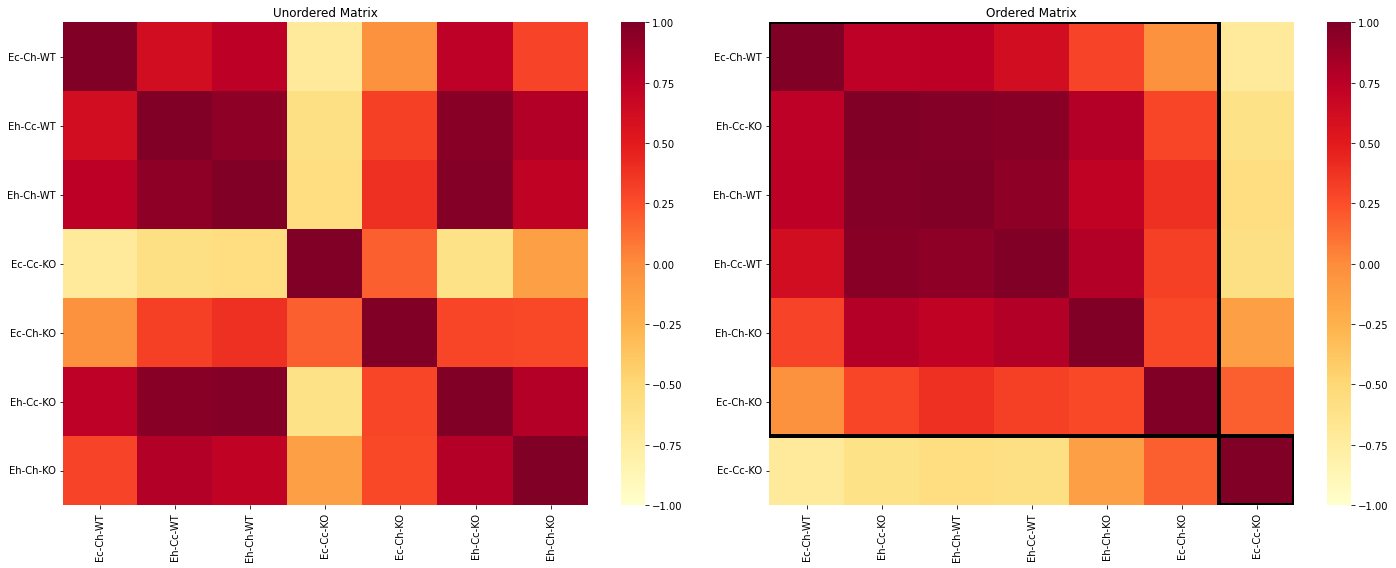

In [154]:
VisualizeClusters(S1, simMat_rows, row_labels,kernelOrder_rows, partition_rows, save= True, filename= 'rows.png')

## Clusters: Columns

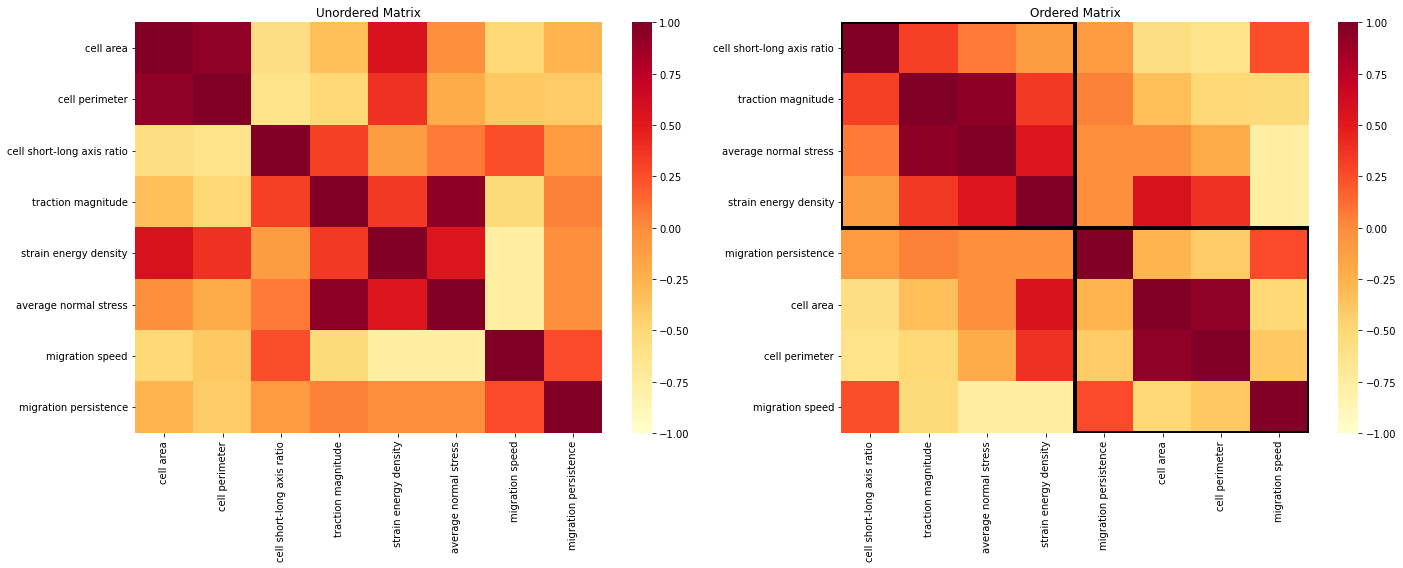

In [155]:
VisualizeClusters(S2, simMat_cols, col_labels,kernelOrder_cols, partition_cols, save= True, filename= 'cols.png')

## Clusters within the Z-score matrix

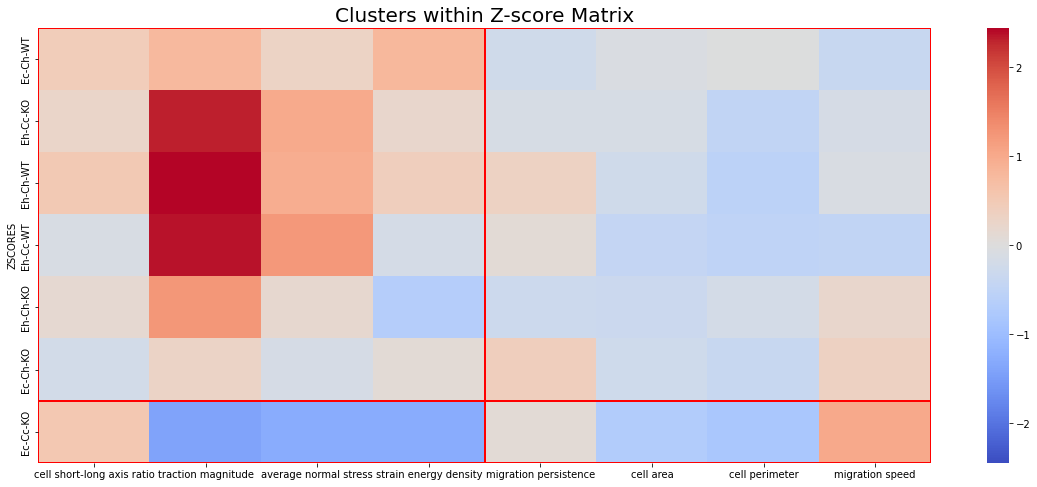

In [156]:
VisualizeZscoreMatrix(zscores, col_labels, row_labels, kernelOrder_rows, kernelOrder_cols,partition_rows, partition_cols)

## Save Matrices as Excel Files

In [ ]:
import scipy.io as sio
test = sio.loadmat('test.mat')
test

{'CONDITIONS': array([[ 1.        ,  0.61313886,  0.74715221, -0.71636208, -0.03274664,
          0.7346948 ,  0.30257088],
        [ 0.61313886,  1.        ,  0.93389826, -0.58123793,  0.31257979,
          0.9622477 ,  0.7912611 ],
        [ 0.74715221,  0.93389826,  1.        , -0.56216608,  0.39157323,
          0.97817212,  0.72905264],
        [-0.71636208, -0.58123793, -0.56216608,  1.        ,  0.18299371,
         -0.60337225, -0.1226989 ],
        [-0.03274664,  0.31257979,  0.39157323,  0.18299371,  1.        ,
          0.29002621,  0.28000997],
        [ 0.7346948 ,  0.9622477 ,  0.97817212, -0.60337225,  0.29002621,
          1.        ,  0.78775622],
        [ 0.30257088,  0.7912611 ,  0.72905264, -0.1226989 ,  0.28000997,
          0.78775622,  1.        ]]),
 'PROPERTIES': array([[ 1.        ,  0.9268125 , -0.56471403, -0.32423952,  0.57774901,
         -0.01861461, -0.49250742, -0.27303146],
        [ 0.9268125 ,  1.        , -0.61991487, -0.49265478,  0.38762843,
   